In [1]:
# import the packages
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import Series

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

In [2]:
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)
import scipy.stats as stats
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [3]:
# import the data under consideration
bankloans = pd.read_csv('C:/Users/tejan/Desktop/Data Analystics/class work/python stats class 14 (logistic regression)/Logistic Regression class files 2/bankloans.csv' )


In [ ]:
df = bankloans

In [5]:
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [7]:
import re
import traceback
import string
import pandas.core.algorithms as algos

In [24]:
# creating IV to check variable importance

max_bin = 20
force_bin = 3


def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
    
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
        
        
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]  
    
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)
        
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)


In [25]:
# defining final function 

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)






In [26]:

final_iv, IV = data_vars(df,df.default)

In [29]:
IV.sort_values('IV')

,VAR_NAME,IV
4,ed,0.045476
6,income,0.222067
7,othdebt,0.255561
1,age,0.275060
0,address,0.329204
2,creddebt,0.507558
5,employ,0.698737
3,debtinc,0.904741


In [13]:
bankloans_existing = bankloans[bankloans.default.isnull() == 0]
bankloans_new = bankloans[bankloans.default.isnull() == 1]


In [14]:
bankloans_existing.default.value_counts()

0.0    517
1.0    183
Name: default, dtype: int64

In [15]:
bankloans_existing.describe(percentiles=[.01,.05,.25,.5,.75,.9,.95,.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,90%,95%,99%,max
age,700.0,34.860000,7.997342,20.000000,21.000000,23.000000,29.000000,34.000000,40.000000,46.000000,49.000000,53.010000,56.00000
ed,700.0,1.722857,0.928206,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,700.0,8.388571,6.658039,0.000000,0.000000,0.000000,3.000000,7.000000,12.000000,18.000000,21.050000,27.010000,31.00000
address,700.0,8.278571,6.824877,0.000000,0.000000,0.000000,3.000000,7.000000,12.000000,18.000000,22.000000,26.010000,34.00000
income,700.0,45.601429,36.814226,14.000000,15.000000,17.000000,24.000000,34.000000,55.000000,82.000000,113.000000,190.300000,446.00000
debtinc,700.0,10.260571,6.827234,0.400000,0.900000,1.900000,5.000000,8.600000,14.125000,19.610000,23.800000,30.701000,41.30000
creddebt,700.0,1.553553,2.117197,0.011696,0.030209,0.107029,0.369059,0.854869,1.901955,3.621504,5.098264,9.891428,20.56131
othdebt,700.0,3.058209,3.287555,0.045584,0.160936,0.376727,1.044178,1.987567,3.923065,7.036180,9.501648,17.184744,27.03360
default,700.0,0.261429,0.439727,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [16]:
bankloans_existing.shape

(700, 9)

In [17]:
# Handling Outliers
bankloans_existing = bankloans_existing.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [18]:
# missing value imputation

bankloans_existing = bankloans_existing.fillna(bankloans_existing.mean())

In [19]:
bankloans_existing

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41.0,3,17.0,12.0,176.0,9.3,9.891428,5.008608,1.0
1,27.0,1,10.0,6.0,31.0,17.3,1.362202,4.000798,0.0
2,40.0,1,15.0,14.0,55.0,5.5,0.856075,2.168925,0.0
3,41.0,1,15.0,14.0,120.0,2.9,2.658720,0.821280,0.0
4,24.0,2,2.0,0.0,28.0,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
695,36.0,2,6.0,15.0,27.0,4.6,0.262062,0.979938,1.0
696,29.0,2,6.0,4.0,21.0,11.5,0.369495,2.045505,0.0
697,33.0,1,15.0,3.0,32.0,7.6,0.491264,1.940736,0.0
698,45.0,1,19.0,22.0,77.0,8.4,2.302608,4.165392,0.0


<AxesSubplot:>

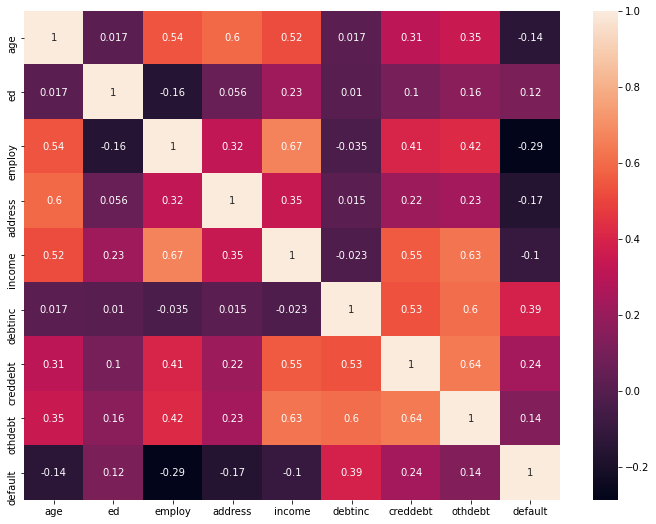

In [20]:
# correlation matrix to check multicoleanearity and insginificant variables

# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (12, 9))
sns.heatmap(bankloans_existing.corr(), annot=True)

In [21]:
# building logistic rgression model using stats
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split

train, test = train_test_split(bankloans_existing, test_size = 0.3, random_state =  42)

In [22]:
test.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [23]:
m1 = sm.logit(formula = '''default ~  employ+ address+ income+ debtinc+ creddebt''', data = train ).fit()

Optimization terminated successfully.
         Current function value: 0.430694
         Iterations 7


In [24]:
# print the model summary stats 
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.266     
Dependent Variable: default          AIC:              434.0800  
Date:               2021-02-05 13:03 BIC:              459.2465  
No. Observations:   490              Log-Likelihood:   -211.04   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      3.2769e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.8689    0.3421  -2.5397  0.0111  -1.5395  -0.1983
employ        -0.2360    0.0339  -6.9599  0.0000  -0.3024  -0.1695
address       -0.0602    0.0220  -2.7339  0.0063  -0.1034  -0.0170
income         0.0036    0.007

In [25]:
m1.predict(train)

357    0.614789
649    0.563556
291    0.065281
420    0.492845
177    0.143656
         ...   
71     0.749610
106    0.129682
270    0.016474
435    0.458194
102    0.099663
Length: 490, dtype: float64

In [26]:
logreg_model = sm.logit('default ~ debtinc', data= bankloans_existing).fit()

Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6


In [27]:
p = logreg_model.predict(bankloans_existing)

In [31]:
# creating somers'd 

# empty dataframe
somersd_df = pd.DataFrame()

# iterate for each of the X - dependant variables and get the Somer's D value
for num_variable in bankloans_existing.columns.difference(['default']):
    
    # execute the logit model
    logreg = sm.logit(formula = str('default ~ ') + str(num_variable), data = bankloans_existing).fit()
    
    # get the predicted probabilities and create a dataframe with the predicted values
    y_score = pd.DataFrame(logreg.predict())
    
    # name the column of the df as score
    y_score.columns = ['Score']
    
    # calculate the Somer's D values
    somers_d = 2 * metrics.roc_auc_score(bankloans_existing['default'], y_score) - 1
    
    # place the variable name and the Somers' D score in a temp dataframe
    temp = pd.DataFrame([num_variable, somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    
    # append the data in the dataframe for all the X variables
    somersd_df = pd.concat([somersd_df, temp], axis=0)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [32]:
# print the Somer's D values for all variables
# Bi-variate analysis to check the predictive power of each independent against dependent
somersd_df.sort_values(by = 'SomersD', ascending = False)

,Variable Name,SomersD
0,debtinc,0.470506
0,employ,0.409138
0,creddebt,0.272378
0,address,0.222384
0,age,0.206329
0,income,0.200273
0,othdebt,0.173806
0,ed,0.148302


In [33]:
IV.sort_values('IV')

In [34]:
# finding VIF

# get all the dependent avriables
features = ' + '.join(bankloans_existing.columns.difference(['default']))


# run the dmatrices
a, b = dmatrices('default ~ ' + features, data = bankloans_existing, return_type = 'dataframe')

# get the VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

vif

,VIF Factor,features
0,36.910987,Intercept
1,1.561802,address
2,2.037593,age
3,2.628899,creddebt
4,3.910509,debtinc
5,1.287345,ed
6,2.401544,employ
7,5.121585,income
8,4.562072,othdebt


In [35]:
m1 = sm.logit(formula = '''default ~  employ+ address+ income+ debtinc+ creddebt''', data = train ).fit()

Optimization terminated successfully.
         Current function value: 0.430694
         Iterations 7


In [36]:
# print the model summary stats 
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.266     
Dependent Variable: default          AIC:              434.0800  
Date:               2021-02-05 13:04 BIC:              459.2465  
No. Observations:   490              Log-Likelihood:   -211.04   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      3.2769e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.8689    0.3421  -2.5397  0.0111  -1.5395  -0.1983
employ        -0.2360    0.0339  -6.9599  0.0000  -0.3024  -0.1695
address       -0.0602    0.0220  -2.7339  0.0063  -0.1034  -0.0170
income         0.0036    0.007

In [37]:
train['pred_prob'] = m1.predict(train)

<ipython-input-37-74ad36bd700c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_prob'] = m1.predict(train)


In [38]:
train_predict = m1.predict(train)
test_predict = m1.predict(test)


In [39]:
# model accuracy | Method 1: AUC
train_auc = metrics.roc_auc_score(train['default'], train_predict)
test_auc = metrics.roc_auc_score(test['default'], test_predict)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.8371205768908266
The AUC for the model built on the Test Data is :  0.8859170997591583


In [40]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(train_predict)
train_predicted_prob.columns = ['prob']
train_predicted_prob

# making a DataFrame with actual and prob columns
train_pf = pd.concat([train['default'], train_predicted_prob], axis = 1)
train_pf.columns = ['actual', 'prob']
train_pf.head(10)

,actual,prob
357,1.0,0.614789
649,0.0,0.563556
291,0.0,0.065281
420,1.0,0.492845
177,0.0,0.143656
456,0.0,0.085058
444,1.0,0.696685
83,0.0,0.311932
453,0.0,0.498220
354,1.0,0.424809


In [41]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(test_predict)
test_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
test_pf = pd.concat([test['default'], test_predicted_prob], axis=1)
test_pf.columns = ['actual','prob']
test_pf.head()

,actual,prob
158,1.0,0.211253
500,0.0,0.497636
396,0.0,0.067929
155,0.0,0.282763
321,1.0,0.341266


In [42]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from sklearn import metrics

cm = metrics.confusion_matrix( train['default'],
                            train_predict>0.5,[1,0])
cm

C:\Users\tejan\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([[ 63,  71],
       [ 28, 328]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

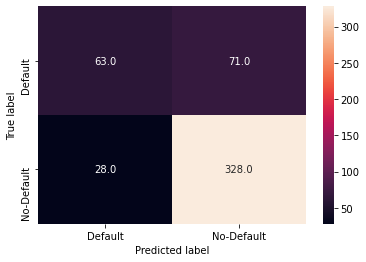

In [43]:
sn.heatmap(cm, annot=True,  fmt='.1f', xticklabels = ["Default", "No-Default"] , yticklabels = ["Default", "No-Default"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [44]:
roc_like_df = pd.DataFrame()
train_temp = train_pf.copy()

for cut_off in np.linspace(0,1,100):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    
    
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)

roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df



,cutoff,sensitivity,specificity,accuracy,total
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.010101,1.000000,0.095506,0.342857,1.095506
0,0.020202,1.000000,0.160112,0.389796,1.160112
0,0.030303,1.000000,0.205056,0.422449,1.205056
0,0.040404,0.992537,0.258427,0.459184,1.250964
...,...,...,...,...,...
0,0.959596,0.022388,1.000000,0.732653,1.022388
0,0.969697,0.014925,1.000000,0.730612,1.014925
0,0.979798,0.007463,1.000000,0.728571,1.007463
0,0.989899,0.000000,1.000000,0.726531,1.000000


In [45]:
# cut-off based on highest sum(sensitivity + specicity) - common way of identifying cut-off
roc_like_df[roc_like_df['total'] == roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.232323,0.858209,0.685393,0.732653,1.543602


In [46]:
# cut-off based on highest accuracy - can be misleading in case imbalanced data
roc_like_df[roc_like_df['accuracy'] == roc_like_df['accuracy'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.484848,0.507463,0.91573,0.804082,1.423193


In [47]:
test_pf['predicted'] = test_pf['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_pf['predicted'] = train_pf['prob'].apply(lambda x: 1 if x > 0.23 else 0)

In [48]:
train_pf

,actual,prob,predicted
357,1.0,0.614789,1
649,0.0,0.563556,1
291,0.0,0.065281,0
420,1.0,0.492845,1
177,0.0,0.143656,0
...,...,...,...
71,0.0,0.749610,1
106,1.0,0.129682,0
270,0.0,0.016474,0
435,0.0,0.458194,1


In [49]:
# confusion matrix of training dataset
pd.crosstab(train_pf['actual'], train_pf['predicted'])

predicted,0,1
actual,,
0.0,242,114
1.0,19,115


In [50]:
cm = metrics.confusion_matrix( train['default'],
                            train_pf['predicted'])
cm

array([[242, 114],
       [ 19, 115]], dtype=int64)

In [51]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_pf.actual, train_pf.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the Train Data is :  0.7285714285714285
The overall accuracy score for the Test Data  is :  0.7523809523809524


In [52]:
# Prediction models on new customers

# predciting new customers good or bad
bankloans_new['prob'] = m1.predict(bankloans_new)
bankloans_new.head()

<ipython-input-52-a431c964ff31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new['prob'] = m1.predict(bankloans_new)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.015101
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.108179
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.656100
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.098785
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.344486


In [53]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)

<ipython-input-53-0a37c460a314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)


In [54]:
bankloans_new.default.value_counts()

0    86
1    64
Name: default, dtype: int64